In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import yaml
import json

from ms_pred import common
from ms_pred.common import plot_utils
from ms_pred.common.plot_utils import *
import copy

from collections import defaultdict
from scipy.stats import sem

set_style()


%load_ext autoreload
%autoreload 2

/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_names = ["nist20", "canopus_train_public"]
# results_folder = Path("../results/figs/")
results_folder = Path("../results/figs_scarf/retrieval")
results_folder.mkdir(parents=True, exist_ok=True)
label_files = [f"../data/spec_datasets/{i}/labels.tsv" for i in dataset_names]
spec_to_smiles = {
    j[0]: j[1]
    for i in label_files
    for j in pd.read_csv(i, sep="\t")[["spec", "smiles"]].values
}

In [3]:
names = [
    "Random",
    "3DMolMS",
    "FixedVocab",
    "NEIMS (FFN)",
    "NEIMS (GNN)",
    "SCARF",
]

dataset_to_res = {}
for dataset_name in dataset_names:
    yaml_files = defaultdict(lambda : [])
    for seed in [1,2,3]:    
        results_files = [
            f"../results/dag_inten_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_50/rerank_eval_random.yaml",
            f"../results/molnetms_baseline_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
            f"../results/graff_ms_baseline_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
            f"../results/ffn_baseline_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
            f"../results/gnn_baseline_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
            f"../results/scarf_inten_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
            # f"../results/dag_inten_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_50/rerank_eval_cos.yaml",
        ]


        for i, j in zip(names, results_files):
            yaml_files[i].append(yaml.safe_load(open(j, "r")))
    dataset_to_res[dataset_name] = yaml_files

In [4]:
out_df = []
keys_to_name = {f"avg_top_{i}": i for i in range(1, 11)}

for dataset, yaml_files in dataset_to_res.items():
    for k, v in yaml_files.items():
        for old_name, new_name in keys_to_name.items():
            new_entry = {
                "Method": k,
                "Top k": new_name,
                "Acc": np.mean([vv[old_name] for vv in v]),
                "Acc 95%": 1.96 * sem([vv[old_name] for vv in v]),
                "Dataset": dataset,
            }
            out_df.append(new_entry)
out_df = pd.DataFrame(out_df)
out_df['Acc_orig'] = out_df['Acc']

In [5]:
out_df["Acc"] = [
    rf"${i:.3f} \pm {j:.3f}$"
    for i, j in zip(out_df["Acc_orig"], out_df["Acc 95%"])
]

In [6]:
out_df

,Method,Top k,Acc,Acc 95%,Dataset,Acc_orig
0,Random,1,$0.026 \pm 0.001$,0.000738,nist20,0.026061
1,Random,2,$0.052 \pm 0.001$,0.001475,nist20,0.052122
2,Random,3,$0.076 \pm 0.002$,0.002094,nist20,0.076207
3,Random,4,$0.098 \pm 0.001$,0.001209,nist20,0.098128
4,Random,5,$0.120 \pm 0.001$,0.000845,nist20,0.119673
...,...,...,...,...,...,...
115,SCARF,6,$0.489 \pm 0.006$,0.006282,canopus_train_public,0.488782
116,SCARF,7,$0.530 \pm 0.005$,0.005477,canopus_train_public,0.530449
117,SCARF,8,$0.569 \pm 0.003$,0.002513,canopus_train_public,0.568590
118,SCARF,9,$0.600 \pm 0.010$,0.009752,canopus_train_public,0.600321


In [7]:
for dataset_name in dataset_names:
    # Filter out df to specific dataset
    df = out_df[out_df["Dataset"] == dataset_name]
    pivoted_tbl = df.reset_index().pivot_table(
        index="Method", values="Acc", columns="Top k", aggfunc="first"
    )
    pivoted_tbl.index.name = None
    # pivoted_tbl = pivoted_tbl.round(3)
    # pivoted_tbl = pivoted_tbl.loc[names]

    display(pivoted_tbl)
    latex = pivoted_tbl.to_latex(
        caption=f"{dataset_name} spectra prediction retrieval accuracy",
        label=f"tab:{dataset_name}_spec_retrieval", escape=False
    )
    print(latex)

Top k,1,2,3,4,5,6,7,8,9,10
3DMolMS,$0.055 \pm 0.003$,$0.105 \pm 0.000$,$0.146 \pm 0.005$,$0.185 \pm 0.007$,$0.225 \pm 0.009$,$0.262 \pm 0.006$,$0.300 \pm 0.004$,$0.332 \pm 0.005$,$0.364 \pm 0.007$,$0.394 \pm 0.008$
FixedVocab,$0.172 \pm 0.004$,$0.304 \pm 0.004$,$0.399 \pm 0.002$,$0.466 \pm 0.007$,$0.522 \pm 0.012$,$0.568 \pm 0.011$,$0.604 \pm 0.011$,$0.638 \pm 0.009$,$0.665 \pm 0.009$,$0.688 \pm 0.006$
NEIMS (FFN),$0.105 \pm 0.003$,$0.243 \pm 0.012$,$0.324 \pm 0.013$,$0.387 \pm 0.011$,$0.440 \pm 0.014$,$0.480 \pm 0.011$,$0.517 \pm 0.012$,$0.549 \pm 0.010$,$0.581 \pm 0.007$,$0.607 \pm 0.005$
NEIMS (GNN),$0.175 \pm 0.005$,$0.305 \pm 0.003$,$0.398 \pm 0.002$,$0.462 \pm 0.004$,$0.515 \pm 0.005$,$0.559 \pm 0.008$,$0.600 \pm 0.008$,$0.632 \pm 0.007$,$0.662 \pm 0.007$,$0.687 \pm 0.005$
Random,$0.026 \pm 0.001$,$0.052 \pm 0.001$,$0.076 \pm 0.002$,$0.098 \pm 0.001$,$0.120 \pm 0.001$,$0.145 \pm 0.002$,$0.167 \pm 0.000$,$0.189 \pm 0.003$,$0.212 \pm 0.004$,$0.233 \pm 0.004$
SCARF,$0.187 \pm 0.008$,$0.321 \pm 0.011$,$0.417 \pm 0.007$,$0.486 \pm 0.008$,$0.541 \pm 0.009$,$0.584 \pm 0.015$,$0.620 \pm 0.014$,$0.652 \pm 0.008$,$0.683 \pm 0.007$,$0.708 \pm 0.009$


\begin{table}
\centering
\caption{nist20 spectra prediction retrieval accuracy}
\label{tab:nist20_spec_retrieval}
\begin{tabular}{lllllllllll}
\toprule
Top k &                 1  &                 2  &                 3  &                 4  &                 5  &                 6  &                 7  &                 8  &                 9  &                 10 \\
\midrule
3DMolMS     &  $0.055 \pm 0.003$ &  $0.105 \pm 0.000$ &  $0.146 \pm 0.005$ &  $0.185 \pm 0.007$ &  $0.225 \pm 0.009$ &  $0.262 \pm 0.006$ &  $0.300 \pm 0.004$ &  $0.332 \pm 0.005$ &  $0.364 \pm 0.007$ &  $0.394 \pm 0.008$ \\
FixedVocab  &  $0.172 \pm 0.004$ &  $0.304 \pm 0.004$ &  $0.399 \pm 0.002$ &  $0.466 \pm 0.007$ &  $0.522 \pm 0.012$ &  $0.568 \pm 0.011$ &  $0.604 \pm 0.011$ &  $0.638 \pm 0.009$ &  $0.665 \pm 0.009$ &  $0.688 \pm 0.006$ \\
NEIMS (FFN) &  $0.105 \pm 0.003$ &  $0.243 \pm 0.012$ &  $0.324 \pm 0.013$ &  $0.387 \pm 0.011$ &  $0.440 \pm 0.014$ &  $0.480 \pm 0.011$ &  $0.517 \pm 0.012$ &  $0.549 \

/tmp/ipykernel_3078057/3637507236.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = pivoted_tbl.to_latex(


Top k,1,2,3,4,5,6,7,8,9,10
3DMolMS,$0.087 \pm 0.003$,$0.159 \pm 0.020$,$0.218 \pm 0.008$,$0.268 \pm 0.012$,$0.317 \pm 0.011$,$0.357 \pm 0.013$,$0.389 \pm 0.012$,$0.427 \pm 0.016$,$0.456 \pm 0.015$,$0.488 \pm 0.010$
FixedVocab,$0.193 \pm 0.007$,$0.314 \pm 0.008$,$0.390 \pm 0.005$,$0.448 \pm 0.010$,$0.492 \pm 0.003$,$0.527 \pm 0.005$,$0.562 \pm 0.007$,$0.587 \pm 0.010$,$0.612 \pm 0.011$,$0.635 \pm 0.011$
NEIMS (FFN),$0.195 \pm 0.005$,$0.313 \pm 0.005$,$0.388 \pm 0.006$,$0.447 \pm 0.012$,$0.488 \pm 0.003$,$0.527 \pm 0.006$,$0.558 \pm 0.014$,$0.585 \pm 0.014$,$0.606 \pm 0.022$,$0.624 \pm 0.020$
NEIMS (GNN),$0.174 \pm 0.014$,$0.285 \pm 0.008$,$0.362 \pm 0.004$,$0.422 \pm 0.001$,$0.471 \pm 0.003$,$0.518 \pm 0.010$,$0.553 \pm 0.013$,$0.586 \pm 0.013$,$0.615 \pm 0.005$,$0.640 \pm 0.010$
Random,$0.033 \pm 0.002$,$0.061 \pm 0.010$,$0.092 \pm 0.007$,$0.118 \pm 0.005$,$0.141 \pm 0.012$,$0.165 \pm 0.009$,$0.191 \pm 0.011$,$0.216 \pm 0.012$,$0.237 \pm 0.014$,$0.258 \pm 0.012$
SCARF,$0.135 \pm 0.014$,$0.242 \pm 0.001$,$0.320 \pm 0.003$,$0.389 \pm 0.008$,$0.444 \pm 0.004$,$0.489 \pm 0.006$,$0.530 \pm 0.005$,$0.569 \pm 0.003$,$0.600 \pm 0.010$,$0.630 \pm 0.015$


\begin{table}
\centering
\caption{canopus_train_public spectra prediction retrieval accuracy}
\label{tab:canopus_train_public_spec_retrieval}
\begin{tabular}{lllllllllll}
\toprule
Top k &                 1  &                 2  &                 3  &                 4  &                 5  &                 6  &                 7  &                 8  &                 9  &                 10 \\
\midrule
3DMolMS     &  $0.087 \pm 0.003$ &  $0.159 \pm 0.020$ &  $0.218 \pm 0.008$ &  $0.268 \pm 0.012$ &  $0.317 \pm 0.011$ &  $0.357 \pm 0.013$ &  $0.389 \pm 0.012$ &  $0.427 \pm 0.016$ &  $0.456 \pm 0.015$ &  $0.488 \pm 0.010$ \\
FixedVocab  &  $0.193 \pm 0.007$ &  $0.314 \pm 0.008$ &  $0.390 \pm 0.005$ &  $0.448 \pm 0.010$ &  $0.492 \pm 0.003$ &  $0.527 \pm 0.005$ &  $0.562 \pm 0.007$ &  $0.587 \pm 0.010$ &  $0.612 \pm 0.011$ &  $0.635 \pm 0.011$ \\
NEIMS (FFN) &  $0.195 \pm 0.005$ &  $0.313 \pm 0.005$ &  $0.388 \pm 0.006$ &  $0.447 \pm 0.012$ &  $0.488 \pm 0.003$ &  $0.527 \pm 0.006$ &  $

/tmp/ipykernel_3078057/3637507236.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = pivoted_tbl.to_latex(


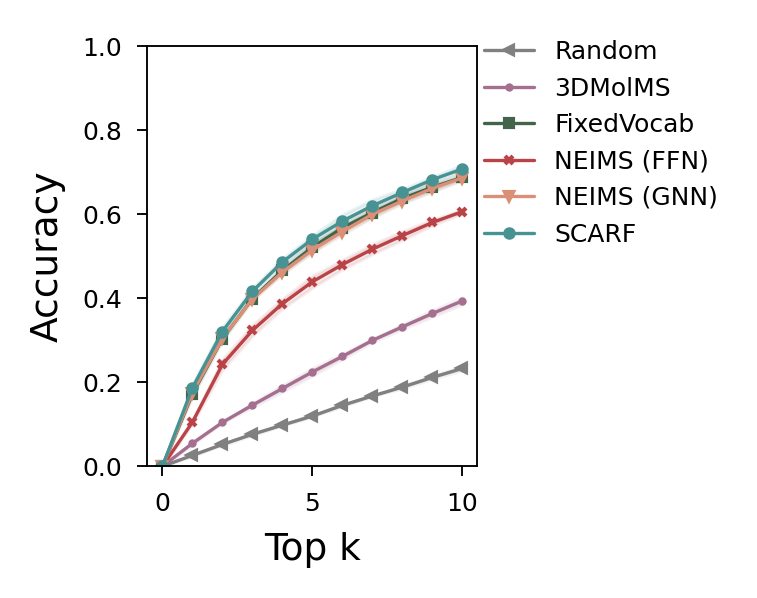

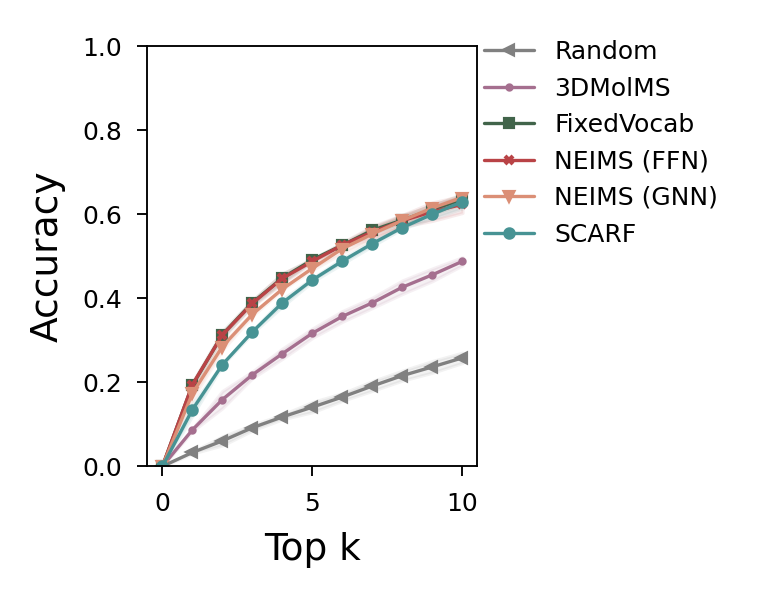

In [8]:
out_df_full = out_df.copy()
method_names = names
for dataset_name in dataset_names:
    sub_df = out_df[out_df["Dataset"] == dataset_name]
    # method_linestyle = dict(zip(method_names, ["o", "v", "x"]))
    figsize = (1.1, 1.4)
    fig = plt.figure(figsize=figsize, dpi=300)
    ax = fig.gca()
    for method in method_names:
        sub_df_method = sub_df[sub_df["Method"] == method]
        topk = [0] + sub_df_method["Top k"].values.tolist()
        accs = [0] + sub_df_method["Acc_orig"].values.tolist()

        bands = [0] + sub_df_method["Acc 95%"].values.tolist()
        # print(bands)

        # ax.step(topk, accs, color=method_colors[method],
        #         linewidth=0.8, where="pre"
        # )
        marker = method_markers[method]
        # print(marker)
        ax.plot(
            topk,
            accs,
            color=method_colors[method],
            linewidth=0.8,
            label=method,
            marker=marker,
            markersize=2,
        )

        # Plot 95% confidence fill between region
        ax.fill_between(
            topk,
            np.array(accs) - np.array(bands),
            np.array(accs) + np.array(bands),
            color=method_colors[method],
            alpha=0.1,
        )

    ax.set_xlabel("Top k")
    ax.set_ylabel("Accuracy")
    # ax.set_xlim([-0.1,5.2])
    ax.set_ylim([0, 1.0])
    ax.legend(frameon=False, facecolor="none", fancybox=False, loc=(0.99, 0.5))
    set_size(*figsize, ax)
    fig.savefig(
        results_folder / f"step_plot_{dataset_name}.pdf",
        dpi=400,
        bbox_inches="tight",
        transparent=True,
    )

## Retrieval by mass

In [9]:
f1 = yaml_files['SCARF'][0]
f1.keys()

dict_keys(['avg_top_1', 'avg_top_10', 'avg_top_2', 'avg_top_3', 'avg_top_4', 'avg_top_5', 'avg_top_6', 'avg_top_7', 'avg_top_8', 'avg_top_9', 'avg_total_decoys', 'avg_true_dist', 'data_folder', 'dataset', 'dist_fn', 'individuals'])

In [10]:
yaml_files.keys()

dict_keys(['Random', '3DMolMS', 'FixedVocab', 'NEIMS (FFN)', 'NEIMS (GNN)', 'SCARF'])

In [11]:
all_res = []
yaml_files["Random"][0]["individuals"][0].keys()
all_res = []
for dataset, yaml_files in dataset_to_res.items():
    for method_name, out_dict in yaml_files.items():
        # Take only the first split
        if len(out_dict) == 0: continue
        individuals = [ii for i in out_dict for ii in i["individuals"]]
        for i, res in enumerate(individuals):
            all_res.append(copy.deepcopy(res))
            all_res[-1]["method"] = method_name
            all_res[-1]["id"] = i
            all_res[-1]["dataset"] = dataset
df = pd.DataFrame(all_res)

In [12]:
df.keys()
mean_df = df.groupby(["method", "dataset", "mass_bin"])["top_1"].mean()
mean_df = mean_df.reset_index()
mean_df = mean_df[mean_df["dataset"] == "nist20"]
pivoted_tbl = mean_df.pivot_table(
    index="method", values="top_1", columns=["dataset", "mass_bin"]
)
pivoted_tbl.index.name = "Method"
pivoted_tbl = pivoted_tbl.round(3)
pivoted_tbl = pivoted_tbl.loc[names]
pivoted_tbl.columns.name = "Mass bin (Da)"
display(pivoted_tbl)
latex = pivoted_tbl.to_latex(
    caption=f"{dataset_name} spectra prediction retrieval accuracy",
    label=f"tab:{dataset_name}_spec_retrieval",
)
print(latex)

# Second df with counts
mean_df = df.groupby(["method", "dataset", "mass_bin"])["top_1"].count()
mean_df = mean_df.reset_index()
mean_df = mean_df[mean_df["dataset"] == "nist20"]
pivoted_tbl = mean_df.pivot_table(
    index="method", values="top_1", columns=["dataset", "mass_bin"]
)
pivoted_tbl.index.name = "Method"
pivoted_tbl = pivoted_tbl.round(3)
pivoted_tbl = pivoted_tbl.loc[names]
pivoted_tbl.columns.name = "Mass bin (Da)"
display(pivoted_tbl)
latex = pivoted_tbl.to_latex(
    caption=f"{dataset_name} spectra prediction retrieval accuracy",
    label=f"tab:{dataset_name}_spec_retrieval",
)
print(latex)

dataset      nist20                                                    \
mass_bin    0 - 200 200 - 300 300 - 400 400 - 500 500 - 600 600 - 700   
Method                                                                  
Random        0.024     0.021     0.027     0.025     0.031     0.048   
3DMolMS       0.039     0.041     0.057     0.077     0.070     0.125   
FixedVocab    0.143     0.184     0.168     0.172     0.196     0.220   
NEIMS (FFN)   0.110     0.122     0.092     0.078     0.111     0.083   
NEIMS (GNN)   0.155     0.192     0.164     0.182     0.147     0.214   
SCARF         0.191     0.211     0.165     0.163     0.168     0.161   

dataset                 
mass_bin    700 - 2000  
Method                  
Random           0.101  
3DMolMS          0.199  
FixedVocab       0.161  
NEIMS (FFN)      0.064  
NEIMS (GNN)      0.161  
SCARF            0.169

\begin{table}
\centering
\caption{canopus_train_public spectra prediction retrieval accuracy}
\label{tab:canopus_train_public_spec_retrieval}
\begin{tabular}{lrrrrrrr}
\toprule
dataset & \multicolumn{7}{l}{nist20} \\
mass\_bin & 0 - 200 & 200 - 300 & 300 - 400 & 400 - 500 & 500 - 600 & 600 - 700 & 700 - 2000 \\
Method      &         &           &           &           &           &           &            \\
\midrule
Random      &   0.024 &     0.021 &     0.027 &     0.025 &     0.031 &     0.048 &      0.101 \\
3DMolMS     &   0.039 &     0.041 &     0.057 &     0.077 &     0.070 &     0.125 &      0.199 \\
FixedVocab  &   0.143 &     0.184 &     0.168 &     0.172 &     0.196 &     0.220 &      0.161 \\
NEIMS (FFN) &   0.110 &     0.122 &     0.092 &     0.078 &     0.111 &     0.083 &      0.064 \\
NEIMS (GNN) &   0.155 &     0.192 &     0.164 &     0.182 &     0.147 &     0.214 &      0.161 \\
SCARF       &   0.191 &     0.211 &     0.165 &     0.163 &     0.168 &     0.161 &      0

/tmp/ipykernel_3078057/382209690.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = pivoted_tbl.to_latex(


dataset      nist20                                                    \
mass_bin    0 - 200 200 - 300 300 - 400 400 - 500 500 - 600 600 - 700   
Method                                                                  
Random         1872      4074      2700      1161       387       168   
3DMolMS        1872      4074      2700      1161       387       168   
FixedVocab     1872      4074      2700      1161       387       168   
NEIMS (FFN)    1872      4074      2700      1161       387       168   
NEIMS (GNN)    1872      4074      2700      1161       387       168   
SCARF          1872      4074      2700      1161       387       168   

dataset                 
mass_bin    700 - 2000  
Method                  
Random             267  
3DMolMS            267  
FixedVocab         267  
NEIMS (FFN)        267  
NEIMS (GNN)        267  
SCARF              267

\begin{table}
\centering
\caption{canopus_train_public spectra prediction retrieval accuracy}
\label{tab:canopus_train_public_spec_retrieval}
\begin{tabular}{lrrrrrrr}
\toprule
dataset & \multicolumn{7}{l}{nist20} \\
mass\_bin & 0 - 200 & 200 - 300 & 300 - 400 & 400 - 500 & 500 - 600 & 600 - 700 & 700 - 2000 \\
Method      &         &           &           &           &           &           &            \\
\midrule
Random      &    1872 &      4074 &      2700 &      1161 &       387 &       168 &        267 \\
3DMolMS     &    1872 &      4074 &      2700 &      1161 &       387 &       168 &        267 \\
FixedVocab  &    1872 &      4074 &      2700 &      1161 &       387 &       168 &        267 \\
NEIMS (FFN) &    1872 &      4074 &      2700 &      1161 &       387 &       168 &        267 \\
NEIMS (GNN) &    1872 &      4074 &      2700 &      1161 &       387 &       168 &        267 \\
SCARF       &    1872 &      4074 &      2700 &      1161 &       387 &       168 &       

/tmp/ipykernel_3078057/382209690.py:31: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = pivoted_tbl.to_latex(


## Plot example spectra

In [13]:
out_df

,Method,Top k,Acc,Acc 95%,Dataset,Acc_orig
0,Random,1,$0.026 \pm 0.001$,0.000738,nist20,0.026061
1,Random,2,$0.052 \pm 0.001$,0.001475,nist20,0.052122
2,Random,3,$0.076 \pm 0.002$,0.002094,nist20,0.076207
3,Random,4,$0.098 \pm 0.001$,0.001209,nist20,0.098128
4,Random,5,$0.120 \pm 0.001$,0.000845,nist20,0.119673
...,...,...,...,...,...,...
115,SCARF,6,$0.489 \pm 0.006$,0.006282,canopus_train_public,0.488782
116,SCARF,7,$0.530 \pm 0.005$,0.005477,canopus_train_public,0.530449
117,SCARF,8,$0.569 \pm 0.003$,0.002513,canopus_train_public,0.568590
118,SCARF,9,$0.600 \pm 0.010$,0.009752,canopus_train_public,0.600321


In [14]:
# Reset index
# out_df = out_df.reset_index()
# out_df = out_df.rename({"index": "Method"}, axis=1)
out_df = out_df.set_index("Method").round(3)
out_df.index.name = None

In [15]:
dataset_name = "nist20"
yaml_files = dataset_to_res[dataset_name]
scarf_inds = yaml_files["SCARF"][0]["individuals"]
gnn_inds = yaml_files["NEIMS (GNN)"][0]["individuals"]
scarf_spec_to_ind = {i["spec_name"]: i["ind_recovered"] for i in scarf_inds}
gnn_spec_to_ind = {i["spec_name"]: i["ind_recovered"] for i in gnn_inds}

In [16]:
scarf_better = [
    k for k, v in scarf_spec_to_ind.items() if v == 1 and v < gnn_spec_to_ind[k]
]
np.random.seed(3)
len(scarf_better)
ex_specs = np.random.choice(scarf_better, 5)
ex_specs = np.random.choice(list(scarf_spec_to_ind.keys()), 5)
print(ex_specs)
# ex_specs = ['nist_1788697', 'nist_1208536']
print(ex_specs)
mols = [Chem.MolFromSmiles(spec_to_smiles[i]) for i in ex_specs]
Draw.MolsToGridImage(
    mols,
)  # figsize=(20,10))
data_folder = Path(f"../data/spec_datasets/{dataset_name}/")

['nist_1477535' 'nist_1657024' 'nist_1343917' 'nist_1309835'
 'nist_1295117']
['nist_1477535' 'nist_1657024' 'nist_1343917' 'nist_1309835'
 'nist_1295117']


In [17]:
def export_ex_specs(
    ex_specs, folder_name="output_examples", add_numbers=True, figsize=(2.1, 1.4)
):
    spec_folder = results_folder / folder_name
    spec_folder.mkdir(exist_ok=True)

    for ex_spec in ex_specs:
        spec_file = data_folder / f"subformulae/no_subform/{ex_spec}.json"
        true_spec = json.load(open(spec_file, "r"))

        export_spec_folder = Path(
            f"../results/scarf_inten_{dataset_name}/split_1_rnd1/preds_export_{dataset_name}/tree_preds_inten"
        )
        pred_spec_file = export_spec_folder / f"pred_{ex_spec}.json"
        pred_spec = json.load(open(pred_spec_file, "r"))
        #print(pred_spec_file, spec_file)

        # Make predictions
        mz, inten = (
            pred_spec["output_tbl"]["formula_mass_no_adduct"],
            pred_spec["output_tbl"]["rel_inten"],
        )
        pred_forms = pred_spec["output_tbl"]["formula"]
        top_forms = np.argsort(inten)[::-1][:5]
        out_map = "\n".join(
            ["\t".join([str(j) for j in i]) for i in list(enumerate(pred_forms))]
        )
        out_info = f"Smiles: {pred_spec['smiles']}, Formula: {pred_spec['cand_form']}\n{out_map}"
        fig = plt.figure(figsize=(figsize), dpi=300)
        ax = fig.gca()
        inten = inten / np.max(inten)
        for ind, (m, i, pred_form) in enumerate(zip(mz, inten, pred_forms)):
            label_kwargs = {"label": "SCARF"} if ind == 0 else {}
            ax.vlines(
                x=m,
                ymin=0,
                ymax=i,
                color=method_colors.get("SCARF"),
                linewidth=0.5,
                **label_kwargs,
            )
            # Make form label
            if ind in top_forms and add_numbers:
                ax.text(x=m, y=i + 0.2, s=f"{ind}", fontsize=6, rotation=90)

        mz, inten = (
            true_spec["output_tbl"]["formula_mass_no_adduct"],
            true_spec["output_tbl"]["rel_inten"],
        )
        for ind, (m, i) in enumerate(zip(mz, inten)):
            label_kwargs = {"label": "True"} if ind == 0 else {}
            ax.vlines(
                x=m,
                ymin=0,
                ymax=-i,
                color="black",
                linewidth=0.5,
                **label_kwargs,
            )
        ax.axhline(y=0, xmin=0, xmax=1, color="black", linewidth=0.1)
        ax.set_xlabel("M/Z")
        ax.set_ylabel("Intensity")
        ax.set_title(f"Spectra: {ex_spec}")
        ax.set_ylim([-1.5, 1.5])
        ax.set_yticklabels([abs(i) for i in ax.get_yticks()])
        ax.legend(**legend_params, loc="upper left")
        set_size(*figsize, ax)
        fig.savefig(
            spec_folder / f"{ex_spec}.pdf",
            dpi=300,
            bbox_inches="tight",
            transparent=True,
        )
        # Clf so it doesn't get displayed
        plt.clf();
        with open(spec_folder / f"{ex_spec}.txt", "w") as fp:
            fp.write(out_info)
        mol_obj = Chem.MolFromSmiles(pred_spec["smiles"])
        plot_utils.export_mol(
            mol_obj, spec_folder / f"{ex_spec}_mol.pdf", width=100, height=100
        )

In [18]:
export_ex_specs(ex_specs=ex_specs);

/tmp/ipykernel_3078057/3492330062.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([abs(i) for i in ax.get_yticks()])
/tmp/ipykernel_3078057/3492330062.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([abs(i) for i in ax.get_yticks()])


<Figure size 812.903x556.291 with 0 Axes>

<Figure size 812.903x556.291 with 0 Axes>

<Figure size 812.903x556.291 with 0 Axes>

<Figure size 812.903x556.291 with 0 Axes>

<Figure size 812.903x556.291 with 0 Axes>

In [19]:
sorted_keys = sorted(list(scarf_spec_to_ind.keys()))
np.random.seed(10)
ex_specs = np.random.choice(sorted_keys, 12)
export_ex_specs(ex_specs=ex_specs, folder_name="si_specs", add_numbers=False);

/tmp/ipykernel_3078057/3492330062.py:65: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([abs(i) for i in ax.get_yticks()])


<Figure size 812.903x556.291 with 0 Axes>

<Figure size 812.903x556.291 with 0 Axes>

<Figure size 812.903x556.291 with 0 Axes>

<Figure size 812.903x556.291 with 0 Axes>

<Figure size 812.903x556.291 with 0 Axes>

<Figure size 812.903x556.291 with 0 Axes>

<Figure size 812.903x556.291 with 0 Axes>

<Figure size 812.903x556.291 with 0 Axes>

<Figure size 812.903x556.291 with 0 Axes>

<Figure size 812.903x556.291 with 0 Axes>

<Figure size 812.903x556.291 with 0 Axes>

<Figure size 812.903x556.291 with 0 Axes>

## Retrieval full pubchem

In [20]:
dataset_name = "nist20"
names = [
    "FixedVocab",
    "NEIMS (FFN)",
    "NEIMS (GNN)",
    "SCARF",
]

# root_dir  = Path("/data/DELETEME/samlg/DELETEME_2024_03_01_ms_pred_preprint_res/results/")
root_dir  = Path("../results/")
pubchem_inds = [50, None]
subsetnum = 500
res_dict = defaultdict(lambda : defaultdict(lambda : []))
for pubchem_num in pubchem_inds:
    for seed in [1,2,3]:
        results_files = [
            root_dir / f"graff_ms_baseline_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_{subsetnum}_{pubchem_num}/rerank_eval_cos.yaml",
            root_dir / f"ffn_baseline_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_{subsetnum}_{pubchem_num}/rerank_eval_cos.yaml",
            root_dir / f"gnn_baseline_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_{subsetnum}_{pubchem_num}/rerank_eval_cos.yaml",
            root_dir / f"scarf_inten_{dataset_name}/split_1_rnd{seed}/retrieval_{dataset_name}_split_1_{subsetnum}_{pubchem_num}/rerank_eval_cos.yaml",
        ]
        for name, yaml_file in zip(names, results_files):
            yaml_files = yaml.safe_load(open(yaml_file, "r"))
            res_dict[pubchem_num][name].append(yaml_files)

In [21]:
out_df = []
keys_to_name = {f"avg_top_{i}": i for i in range(1, 11)}

for dataset, yaml_files in res_dict.items():
    for k, v in yaml_files.items():
        for old_name, new_name in keys_to_name.items():
            new_entry = {
                "Method": k,
                "Top k": new_name,
                "Acc": np.mean([vv[old_name] for vv in v]),
                "Acc_sem": 1.96 * sem([vv[old_name] for vv in v]),
                "Dataset": dataset if dataset is not None else "None",
            }
            out_df.append(new_entry)
out_df = pd.DataFrame(out_df)

In [22]:
out_df_temp = out_df.copy()
# Subset to where "Top k" in [1,2,3]
out_df_temp = out_df_temp[out_df_temp["Top k"].isin([1, 2, 3])]

# Create joint string with acc_sem
out_df_temp["Acc"] = [
    rf"${i:.3f} \pm {j:.3f}$"
    for i, j in zip(out_df_temp["Acc"], out_df_temp["Acc_sem"])
]

out_df_pivot = out_df_temp.pivot_table(
    index="Method",
    columns=["Dataset", "Top k"],
    values="Acc",
    aggfunc="first"
)  # aggfunc=lambda x: "&".join(x))

out_df_pivot_sorted = out_df_pivot.loc[names]
# out_df_pivot_sorted = out_df_pivot_sorted.swaplevel(0, 1, axis=1).round(3)

metric_order = {"Cosine sim.": 1, "Coverage": 2, "Valid": 3, "Time (s)": 4}
metric_order = ["Cosine sim.", "Coverage", "Valid", "Time (s)"]
dataset_order = {
    "nist20": 2,
    "canopus_train_public": 1,
}
dataset_order = ["canopus_train_public", "nist20"]


# Rename level 1 of column name to be "Pubchem limit"
out_df_pivot_sorted.columns.names = ["Pubchem limit", "Top k"]

# # Sort columns and make time last
out_df_pivot_sorted.index.name = None
display(out_df_pivot_sorted)
latex = out_df_pivot_sorted.to_latex(
    caption="Retrieval accuracy NIST20", label="tab:retrieval_acc_all", escape=False
)
print(latex)

Pubchem limit                 50                                        \
Top k                          1                  2                  3   
FixedVocab     $0.168 \pm 0.006$  $0.308 \pm 0.006$  $0.410 \pm 0.010$   
NEIMS (FFN)    $0.102 \pm 0.004$  $0.237 \pm 0.006$  $0.315 \pm 0.009$   
NEIMS (GNN)    $0.169 \pm 0.007$  $0.300 \pm 0.008$  $0.402 \pm 0.010$   
SCARF          $0.204 \pm 0.017$  $0.326 \pm 0.010$  $0.432 \pm 0.017$   

Pubchem limit               None                                        
Top k                          1                  2                  3  
FixedVocab     $0.145 \pm 0.007$  $0.258 \pm 0.008$  $0.323 \pm 0.003$  
NEIMS (FFN)    $0.087 \pm 0.006$  $0.183 \pm 0.015$  $0.236 \pm 0.014$  
NEIMS (GNN)    $0.138 \pm 0.008$  $0.239 \pm 0.011$  $0.312 \pm 0.016$  
SCARF          $0.167 \pm 0.005$  $0.258 \pm 0.002$  $0.336 \pm 0.006$

\begin{table}
\centering
\caption{Retrieval accuracy NIST20}
\label{tab:retrieval_acc_all}
\begin{tabular}{lllllll}
\toprule
Pubchem limit & \multicolumn{3}{l}{50} & \multicolumn{3}{l}{None} \\
Top k &                  1 &                  2 &                  3 &                  1 &                  2 &                  3 \\
\midrule
FixedVocab  &  $0.168 \pm 0.006$ &  $0.308 \pm 0.006$ &  $0.410 \pm 0.010$ &  $0.145 \pm 0.007$ &  $0.258 \pm 0.008$ &  $0.323 \pm 0.003$ \\
NEIMS (FFN) &  $0.102 \pm 0.004$ &  $0.237 \pm 0.006$ &  $0.315 \pm 0.009$ &  $0.087 \pm 0.006$ &  $0.183 \pm 0.015$ &  $0.236 \pm 0.014$ \\
NEIMS (GNN) &  $0.169 \pm 0.007$ &  $0.300 \pm 0.008$ &  $0.402 \pm 0.010$ &  $0.138 \pm 0.008$ &  $0.239 \pm 0.011$ &  $0.312 \pm 0.016$ \\
SCARF       &  $0.204 \pm 0.017$ &  $0.326 \pm 0.010$ &  $0.432 \pm 0.017$ &  $0.167 \pm 0.005$ &  $0.258 \pm 0.002$ &  $0.336 \pm 0.006$ \\
\bottomrule
\end{tabular}
\end{table}



/tmp/ipykernel_3078057/426368601.py:36: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex = out_df_pivot_sorted.to_latex(
